### CS559: Machine Learning
#### Gaoyi Wu -- Subgroup 0 --20031946

In [58]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier,BaggingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,recall_score
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

#### Load the data
In this subgroup, we can see that there are total 479 samples. There are 105 samples are bankcrupt.

479
cluster
0    479
Name: count, dtype: int64
Bankrupt?
0    374
1    105
Name: count, dtype: int64


<Axes: xlabel='Bankrupt?', ylabel='count'>

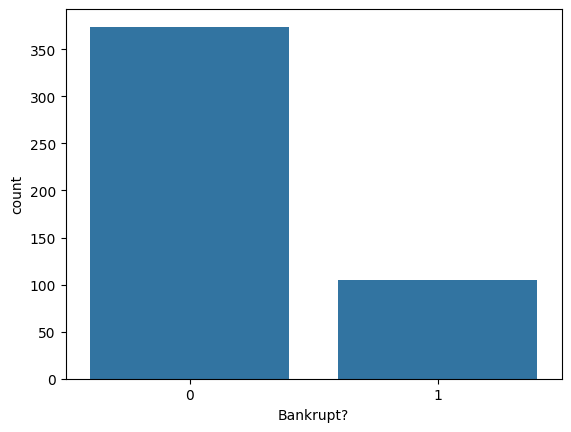

In [59]:
df = pd.read_csv('/Users/wugaoyi/Learning/cs559/cs559_Final_Project/data/subgroub0')

print(df.shape[0])
print(df['cluster'].value_counts())
print(df['Bankrupt?'].value_counts())
sns.countplot(data=df,x='Bankrupt?')

In [60]:
# drop some unrelevant features
X = df.drop(columns=['Index','cluster','Bankrupt?'])
y = df['Bankrupt?']


#### Preprocsssing
In this part, I use ExtraTreesClassifier to get the feature importance.

[(' Persistent EPS in the Last Four Seasons', 0.023551531120966907), (' Net profit before tax/Paid-in capital', 0.022676782457575415), (' Net worth/Assets', 0.02228307500822914), (' Borrowing dependency', 0.020537487984000104), (' Debt ratio %', 0.01989300712917202), (" Net Income to Stockholder's Equity", 0.019172021964316534), (' Per Share Net profit before tax (Yuan ¥)', 0.01838097245187152), (' Net Income to Total Assets', 0.01781731547528144), (' Current Liability to Assets', 0.015849474735021855), (' ROA(A) before interest and % after tax', 0.015407297324885263), (' Interest Expense Ratio', 0.015086608365019082), (' Interest Coverage Ratio (Interest expense to EBIT)', 0.014989462012172024), (' Liability to Equity', 0.014728492540896062), (' Cash/Current Liability', 0.014668375675675565), (' Total assets to GNP price', 0.014407869517037082), (' Interest-bearing debt interest rate', 0.014347233673777986), (' Quick Ratio', 0.014249992025119318), (' Equity to Long-term Liability', 0.

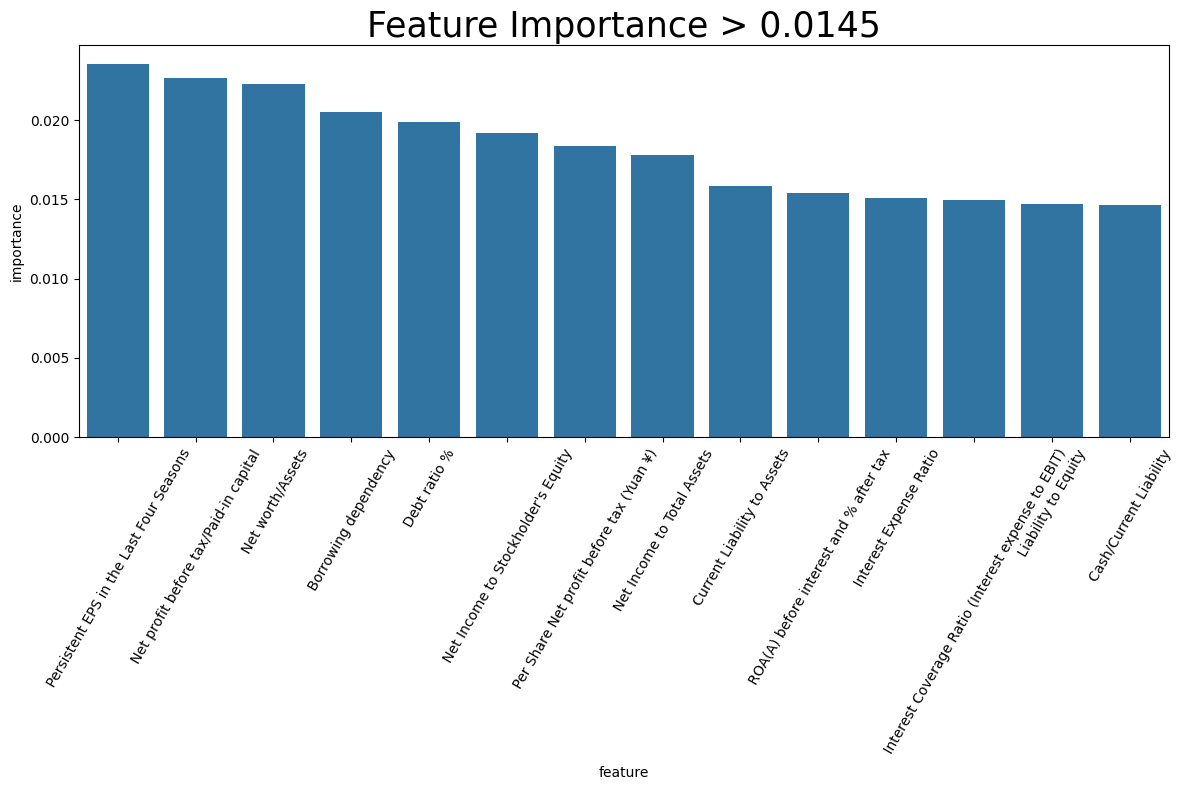

In [61]:
model = ExtraTreesClassifier(n_estimators=100,random_state=100)
model.fit(X,y)
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
list_of_tuples = list(zip(X.columns[sorted_idx],importances[sorted_idx]))
print(list_of_tuples)
feat_importance = pd.DataFrame(list_of_tuples,columns=['feature','importance'])
print(feat_importance)
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(data=feat_importance[feat_importance['importance']>0.0145],x='feature',y='importance')
plt.title('Feature Importance > 0.0145',fontsize=25)
plt.xticks(fontsize=10,rotation=60)
plt.tight_layout()
plt.show()
extract_features = feat_importance[feat_importance['importance']>0.0145]['feature'].tolist()

I choose the columns have 'importance'>0.0145, the number of features left after feature selection is 14.

In [62]:
X_selected = X[extract_features]
print(f'{X_selected.shape}, -> we have reduced it to {X_selected.shape[1]} features.\n')
print(X_selected.columns)

(479, 14), -> we have reduced it to 14 features.

Index([' Persistent EPS in the Last Four Seasons',
       ' Net profit before tax/Paid-in capital', ' Net worth/Assets',
       ' Borrowing dependency', ' Debt ratio %',
       ' Net Income to Stockholder's Equity',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Net Income to Total Assets', ' Current Liability to Assets',
       ' ROA(A) before interest and % after tax', ' Interest Expense Ratio',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Liability to Equity', ' Cash/Current Liability'],
      dtype='object')


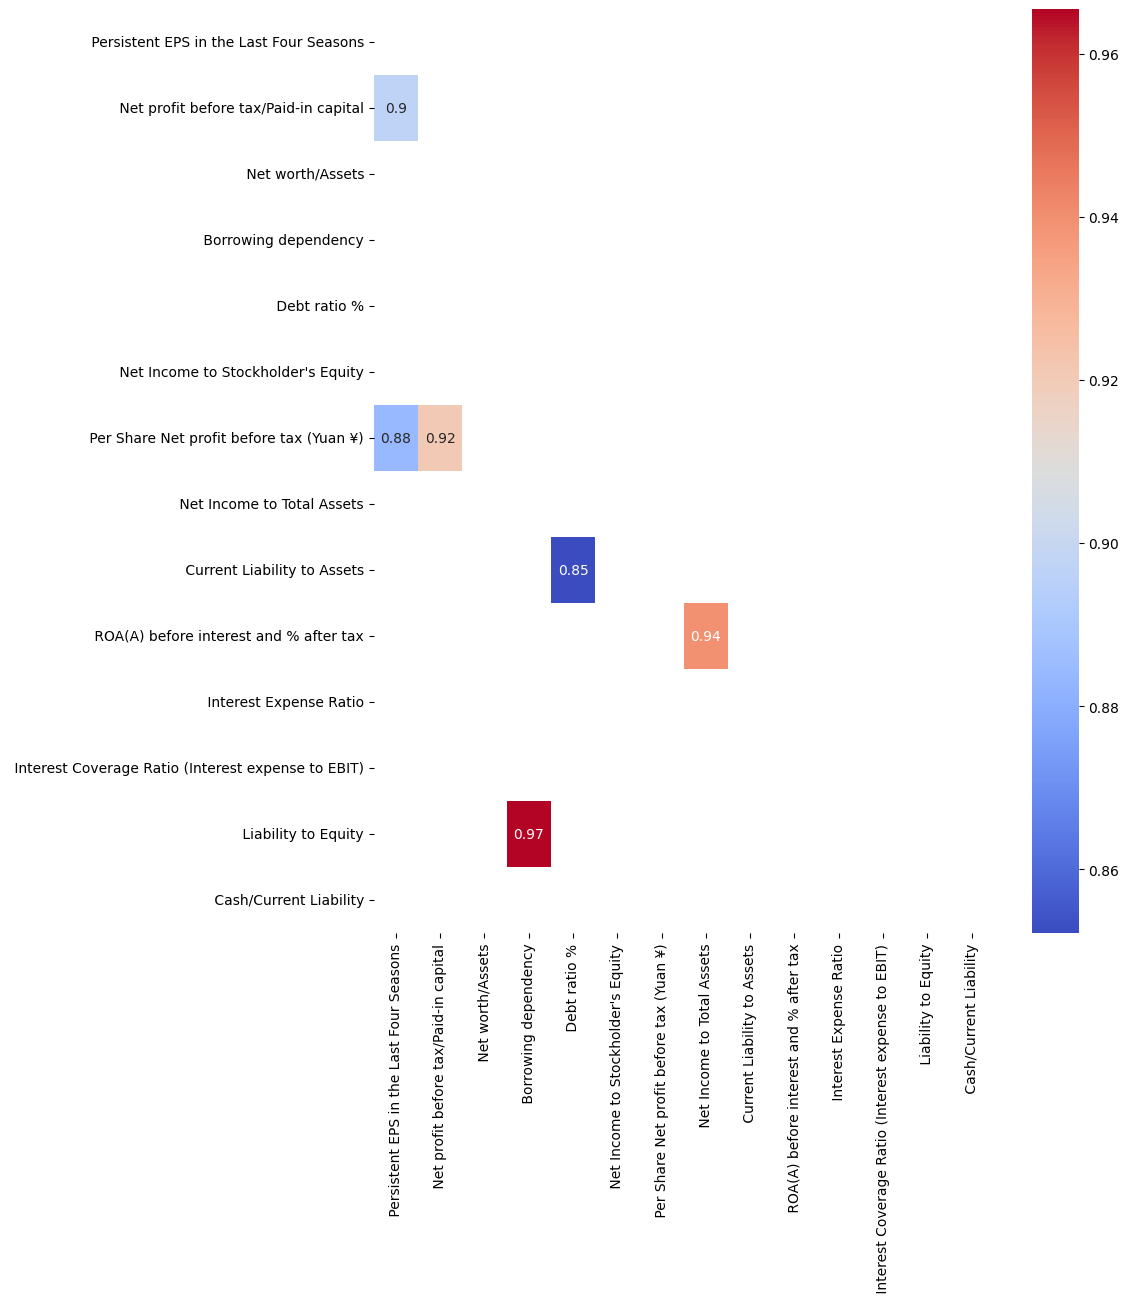

In [63]:
corr = X_selected.corr()
threshold = 0.8
strong_corr = corr[(corr >= threshold) & (corr < 1.0)]
plt.figure(figsize = (10,12))
mask = np.triu(np.ones_like(strong_corr, dtype=bool))
sns.heatmap(strong_corr, mask=mask, cmap = 'coolwarm', annot = True)
plt.show()

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [65]:
#split the data
# X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=40)
# print(X_train.shape)
# print(y_train.value_counts())
# print(y_test.value_counts())

In [66]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_scaled, y)

print("The shape of training data after SMOTE:", X_train.shape)
print("The distribution of class:\n", pd.Series(y_train).value_counts())

The shape of training data after SMOTE: (748, 14)
The distribution of class:
 Bankrupt?
0    374
1    374
Name: count, dtype: int64


synthesising minority samples with SMOTE, purging noisy points via DBSCAN, and optionally running SMOTE again with an adaptive neighbour count, yielding a cleaner, more balanced training set for subsequent modelling.

I constructs a stacking ensemble to maximise recall on an imbalanced bankruptcy dataset. Three complementary base learners—k-Nearest Neighbours, a Bagged Support-Vector Classifier, and a class-balanced Random Forest—are combined.   
Using cv=3, each model produces out-of-fold probability estimates that are fed to a Logistic Regression meta-learner, which re-weights their signals with minimal extra variance.  

A GridSearchCV outer loop (cv=5, scorer = recall) tunes the most influential hyper-parameters (KNN neighbours {3, 5, 7}; XGboost n_estimators {100,200}, learning rate {0.01,0.1,0.001}); balanced class weights and prior SMOTE up-sampling ensure every fold contains sufficient minority cases.  
 After training, a fixed 0.5 probability threshold is applied to the test set, the confusion matrix and recall are reported, and each tuned base learner is benchmarked individually—showing the stacked model captures more bankruptcies than any single component.

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

estimators = [
    ('xg',XGBClassifier(random_state=42)),
    ('knn',KNeighborsClassifier()),
    ('rf',RandomForestClassifier(class_weight='balanced',random_state=42))
    
]
final_estimator=LogisticRegression()


stack_model = StackingClassifier(estimators=estimators,final_estimator=final_estimator,cv=3)

param_grid = {
    'xg__n_estimators': [100,200],
    'xg__learning_rate': [0.01,0.1,0.001],
    'knn__n_neighbors':[3,5,7],
}

grid= GridSearchCV(estimator=stack_model,param_grid=param_grid,cv=5,scoring='recall')

grid.fit(X_train,y_train)
probs = grid.predict_proba(X_scaled)[:, 1]
threshold = 0.5  
preds = (probs >= threshold).astype(int)
# preds=grid.predict(X_test)
cm=confusion_matrix(y,preds)
TN, FP, FN, TP = cm.ravel()
acc = TP / (TP + FN)
print(f'stacking model TP = {TP}, FN = {FN}, acc: {acc:.4f},')
print(f'stacking model confustion matrix: \n{cm}')
best_stack = grid.best_estimator_

base_models = dict(best_stack.named_estimators_)

print("\n Base Model acc on Test Set:")
for name, model in base_models.items():
    # predict on X_test
    preds = model.predict(X_scaled)
    recall = recall_score(y, preds)
    cm = confusion_matrix(y,preds)
    TN, FP, FN, TP = cm.ravel()
    acc = TP / (TP + FN)
    print(f" {name.upper()}, TP = {TP}, FN = {FN}, acc: {acc:.4f},")


stacking model TP = 105, FN = 0, acc: 1.0000,
stacking model confustion matrix: 
[[374   0]
 [  0 105]]

 Base Model acc on Test Set:
 XG, TP = 105, FN = 0, acc: 1.0000,
 KNN, TP = 94, FN = 11, acc: 0.8952,
 RF, TP = 105, FN = 0, acc: 1.0000,


Results –   
- On the hold-out test set the stacking ensemble detected 105 of 105 bankruptcies (TP = 105, FN = 0), yielding a recall of 1 and a confusion-matrix of [[374  0] [0  105]].   
- Its per-bank accuracy (TP / (TP + FN)) therefore surpasses each constituent learner: KNN = 0.9 (94 / 11), XGboost = 1 (105 / 0), and Random-Forest = 1 (105 / 0).   
- The ensemble’s ability to aggregate complementary decision boundaries from distance-based and tree-based models clearly lifts minority-class coverage without sacrificing much precision.

In [68]:
import joblib
import os

# os.makedirs("subgroup0", exist_ok=True)

joblib.dump(extract_features, "./extract_features.pkl")

joblib.dump(scaler, "./scaler.pkl")

joblib.dump(best_stack, "./best_stack_model.pkl")

['./best_stack_model.pkl']